In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score


In [2]:
df_best_fundamental = pd.read_csv('./best_fundamental.csv')
df_best_fundamental.head()

,ticker,pe_ratio,profitability,leverage,operating_efficiency,total_score,company name,sektor
0,AAPL,34.520548,5,2,2,9,Apple Inc.,"Technology Hardware, Storage & Peripherals"
1,AMAT,22.693259,5,2,2,9,Applied Materials,Semiconductor Materials & Equipment
2,AMZN,44.513125,5,2,2,9,Amazon,Broadline Retail
3,APH,37.142858,5,2,2,9,Amphenol,Electronic Components
4,AVY,27.582262,5,2,2,9,Avery Dennison,Paper & Plastic Packaging Products & Materials


In [3]:
ticker = 'AAPL'


f = pd.read_csv(f'./stock_dfs2/{ticker}.csv')
f.head()
# len(f)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-02 00:00:00-05:00,71.878863,72.936766,71.624097,72.876106,135480400,0.0,0.0
1,2020-01-03 00:00:00-05:00,72.099649,72.931893,71.941936,72.167587,146322800,0.0,0.0
2,2020-01-06 00:00:00-05:00,71.284408,72.781476,71.032063,72.742653,118387200,0.0,0.0
3,2020-01-07 00:00:00-05:00,72.752371,73.009565,72.179750,72.400551,108872000,0.0,0.0
4,2020-01-08 00:00:00-05:00,72.102106,73.868505,72.102106,73.565208,132079200,0.0,0.0


# Pelabelan
- 0 = hold
- 1 = local minima
- 2 = local maxima


In [35]:
def add_feature(f):
    n = 10 
    f['loc_min'] = f.iloc[argrelextrema(f.Close.values, np.less_equal, order=n)[0]]['Close']
    f['loc_max'] = f.iloc[argrelextrema(f.Close.values, np.greater_equal, order=n)[0]]['Close']
    f['hold'] = ~f.index.isin(f['loc_min'].dropna().index) & ~f.index.isin(f['loc_max'].dropna().index)
    f['label'] = 0  
    f.loc[f['loc_min'].notna(), 'label'] = 1
    f.loc[f['loc_max'].notna(), 'label'] = 2
    return f


def gambar(f,target='label'):
    f['Date'] = pd.to_datetime(f['Date'], utc=True)
    plt.figure(figsize=(12, 6))
    plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
    plt.scatter(f['Date'][f[target] == 1], f['Close'][f[target] == 1], 
               color='green', label='Label 1 (Local Minima)', marker='o')
    plt.scatter(f['Date'][f[target] == 2], f['Close'][f[target] == 2], 
               color='red', label='Label 2 (Local Maxima)', marker='o')

    plt.title('Price Chart with Labels')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


In [5]:
def split_data(f):
    f['Date'] = pd.to_datetime(f['Date'],utc=True)
    f = f.sort_values(by='Date')
    train_ratio = 0.85
    split_index = int(len(f) * train_ratio)
    train_data = f.iloc[:split_index]
    test_data = f.iloc[split_index:]
    print(f"Training data size: {len(train_data)}")
    print(f"Test data size: {len(test_data)}")
    return train_data, test_data

In [6]:
train_data, test_data = split_data(f)

Training data size: 1005
Test data size: 178


Text(0, 0.5, 'Close Price')

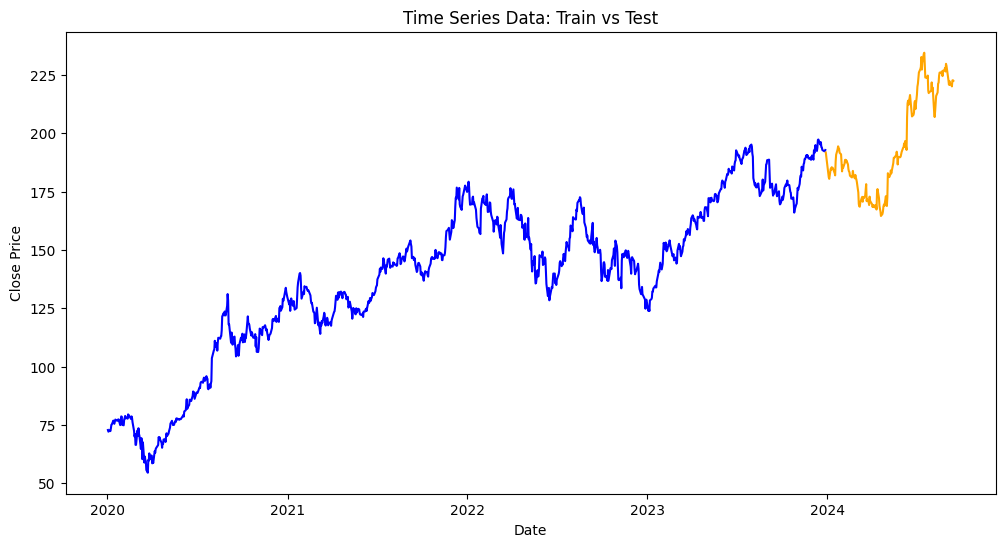

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data', color='orange')
plt.title('Time Series Data: Train vs Test')
plt.xlabel('Date')
plt.ylabel('Close Price')

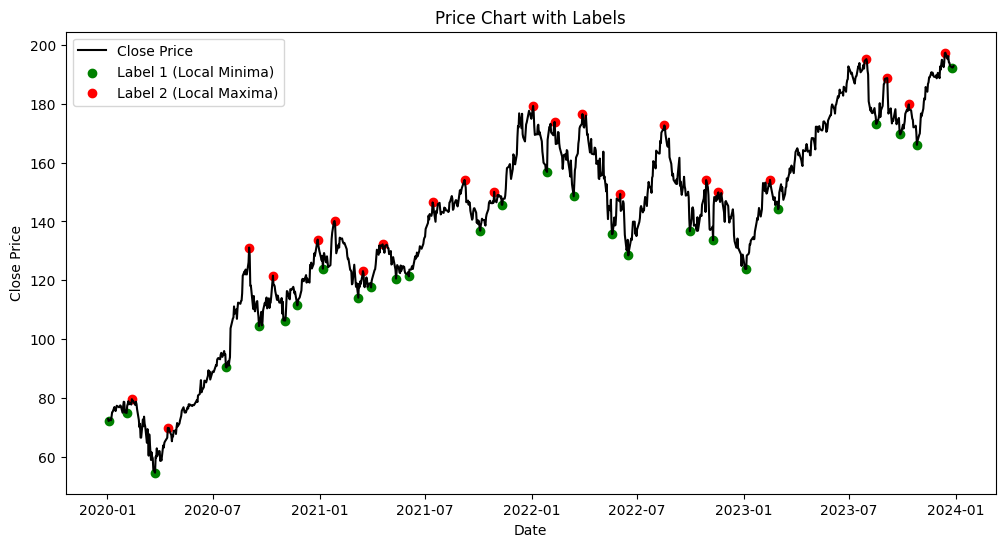

In [8]:
trein = add_feature(train_data)
gambar(train_data)

In [9]:
trein['label'].value_counts()

label
0    956
1     26
2     23
Name: count, dtype: int64

In [10]:
def add_technical_indicators(df, window=10):
    df = df.copy()
    
    df['SMA'] = df['Close'].rolling(window=window).mean()
    
    weights = np.arange(1, window + 1)
    df['WMA'] = df['Close'].rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )
    
    df['Momentum'] = df['Close'].diff(window)
    
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df['Stochastic_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=window).mean()
    
    change = df['Close'].diff(1)
    gain = (change.where(change > 0, 0)).rolling(window=window).mean()
    loss = (-change.where(change < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['Williams_R'] = ((high_max - df['Close']) / (high_max - low_min)) * -100
    
    df['A/D_Oscillator'] = ((df['High'] - df['Close'].shift(1)) / 
                           (df['High'] - df['Low']))
    
    mean_deviation = lambda x: np.mean(np.abs(x - np.mean(x)))
    df['CCI'] = ((df['Close'] - df['Close'].rolling(window=window).mean()) / 
                 (0.015 * df['Close'].rolling(window=window).apply(mean_deviation, raw=True)))
    
    return df


In [11]:
features = ['SMA', 'WMA',
       'Momentum', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD',
       'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

In [12]:
trein = add_technical_indicators(trein)
trein[features]

,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.056520,-0.011304,NaN,0.056353,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,-0.054284,-0.019900,NaN,0.350911,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,-0.079203,-0.031761,NaN,0.321653,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,-0.004917,-0.026392,NaN,0.831043,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1000,195.217220,195.277716,0.408432,39.755833,72.834386,51.420586,2.975160,3.404839,-60.244167,0.628486,-63.130800
1001,195.007018,194.850609,-2.102020,26.585327,65.820786,42.501791,2.647960,3.253463,-73.414673,0.299187,-92.523202
1002,194.994067,194.362100,-0.129501,16.835452,60.794720,49.462396,2.317722,3.066315,-83.164548,0.273590,-114.700630
1003,194.838655,193.894057,-1.554123,24.150041,54.708528,42.682813,2.040523,2.861157,-75.849959,0.186719,-94.327978


In [13]:
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


lgbm_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__num_leaves': [31, 62, 93]
}

# 1. Pipeline untuk Logistic Regression dengan SMOTE
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# 2. Pipeline untuk XGBoost dengan SMOTE
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

# 3. Pipeline untuk Random Forest dengan SMOTE
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 4. Pipeline untuk LightGBM dengan SMOTE
lgbm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=42))
])

def train_evaluate_model(X, y, pipeline, params, model_name):
    df = pd.DataFrame(X, columns=features)
    df['label'] = y
    df_clean = df.dropna()
    
    X_clean = df_clean[features]
    y_clean = df_clean['label']
    
    # Print class distribution before SMOTE
    print("\nClass distribution before SMOTE:")
    print(Counter(y_clean))
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    }
    # Grid Search dengan Cross Validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring=scoring,
        refit='accuracy'
    )
    
    # Fit model
    grid_search.fit(X_clean, y_clean)
    pipeline_fitted = pipeline.fit(X_clean, y_clean)
    X_resampled, y_resampled = pipeline_fitted.named_steps['smote'].fit_resample(X_clean, y_clean)
    
    print("\nClass distribution after SMOTE:")
    print(Counter(y_resampled))
    
    # Print results
    print(f"\nBest parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Get all CV results
    cv_results = grid_search.cv_results_
    mean_accuracy = cv_results['mean_test_accuracy'][grid_search.best_index_]
    mean_f1 = cv_results['mean_test_f1'][grid_search.best_index_]
    mean_precision = cv_results['mean_test_precision'][grid_search.best_index_]
    mean_recall = cv_results['mean_test_recall'][grid_search.best_index_]
    
    print("\nCross-validation metrics for best parameters:")
    print(f"Accuracy: {mean_accuracy:.4f}")
    print(f"F1-score: {mean_f1:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")
    
    return grid_search

# Function untuk train semua model tetap sama
def train_all_models(X, y):
    models = {
        'Logistic Regression': (lr_pipeline, lr_params),
        'XGBoost': (xgb_pipeline, xgb_params),
        'Random Forest': (rf_pipeline, rf_params),
        'LightGBM': (lgbm_pipeline, lgbm_params)
    }
    
    trained_models = {}
    
    for model_name, (pipeline, params) in models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print('='*50)
        
        trained_model = train_evaluate_model(X, y, pipeline, params, model_name)
        trained_models[model_name] = trained_model
    
    return trained_models
X = trein[features]  # DataFrame dengan features
y = trein['label']   # Series dengan label
trained_models = train_all_models(X, y)


Training Logistic Regression

Class distribution before SMOTE:
Counter({0: 939, 1: 25, 2: 23})
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Class distribution after SMOTE:
Counter({0: 939, 1: 939, 2: 939})

Best parameters for Logistic Regression:
{'classifier__C': 0.001, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Best cross-validation accuracy: 0.9514

Cross-validation metrics for best parameters:
Accuracy: 0.9514
F1-score: 0.9277
Precision: 0.9051
Recall: 0.9514

Training XGBoost

Class distribution before SMOTE:
Counter({0: 939, 1: 25, 2: 23})
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Class distribution after SMOTE:
Counter({0: 939, 1: 939, 2: 939})

Best parameters for XGBoost:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}

Best cross-validation accuracy: 0.8662

Cross-validation metrics for best parameters:
Accuracy: 0.8662
F1-score: 0.8869


In [14]:
trained_models

{'Logistic Regression': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                        ('scaler', StandardScaler()),
                                        ('classifier',
                                         LogisticRegression(random_state=42))]),
              n_jobs=-1,
              param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear', 'saga']},
              refit='accuracy',
              scoring={'accuracy': 'accuracy',
                       'f1': make_scorer(f1_score, response_method='predict', average=weighted),
                       'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                       'recall': make_scorer(recall_score, response_method='predict', average=weighted)},
              verbose=1),
 'XGBoost': GridSearch

In [15]:
tes = add_technical_indicators(test_data)
tes[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 1005 to 1182
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMA             169 non-null    float64
 1   WMA             169 non-null    float64
 2   Momentum        168 non-null    float64
 3   Stochastic_K    169 non-null    float64
 4   Stochastic_D    160 non-null    float64
 5   RSI             169 non-null    float64
 6   MACD            178 non-null    float64
 7   MACD_Signal     178 non-null    float64
 8   Williams_R      169 non-null    float64
 9   A/D_Oscillator  177 non-null    float64
 10  CCI             169 non-null    float64
dtypes: float64(11)
memory usage: 15.4 KB


In [16]:
clean_test_df = tes.dropna(subset=features)
clean_test_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1023,2024-01-26 05:00:00+00:00,193.535594,194.023731,191.214400,191.692581,44594000,0.0,0.0,189.538762,191.471066,6.804169,75.373051,74.639917,68.135919,0.836389,-0.272093,-24.626949,0.209211,35.725974
1024,2024-01-29 05:00:00+00:00,191.284128,191.473412,188.863322,191.005188,47145600,0.0,0.0,190.117564,191.737689,5.788025,71.081994,77.707358,65.138058,0.842529,-0.049169,-28.918006,-0.083970,16.896934
1025,2024-01-30 05:00:00+00:00,190.218194,191.074943,186.761310,187.329147,55859400,0.0,0.0,190.556897,191.230704,4.393326,48.134284,78.336995,60.709076,0.544493,0.069563,-51.865716,0.016171,-74.534143
1026,2024-01-31 05:00:00+00:00,186.332931,186.392717,183.653113,183.702911,55467800,0.0,0.0,190.728247,189.984525,1.713501,0.415527,74.730307,53.694166,0.015511,0.058753,-99.584473,-0.341812,-176.928064
1027,2024-02-01 05:00:00+00:00,183.294480,186.243282,183.125124,186.153625,64885400,0.0,0.0,190.551918,189.152775,-1.763290,24.203810,67.719245,45.528093,-0.203611,0.006280,-75.796190,0.814702,-101.319311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2024-09-09 04:00:00+00:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0,224.822002,223.362913,-5.929993,25.909927,47.450567,33.663899,0.750622,1.638540,-74.090073,0.098684,-79.609326
1179,2024-09-10 04:00:00+00:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0,224.115002,222.506185,-7.069992,20.974680,40.791340,31.004827,0.427728,1.396378,-79.025320,0.119998,-79.228580
1180,2024-09-11 04:00:00+00:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0,223.578003,222.241640,-5.369995,36.705738,35.358096,36.779902,0.373294,1.191761,-63.294262,0.573076,-21.036709
1181,2024-09-12 04:00:00+00:00,222.500000,223.550003,219.820007,222.770004,37498200,0.0,0.0,223.206003,222.094731,-3.720001,37.384335,33.842997,40.148288,0.335167,1.020442,-62.615665,0.238606,-11.741234


In [17]:
def predict_with_best_models(trained_models, X_test):
    predictions = {}
    probabilities = {}
    
    for model_name, grid_search in trained_models.items():
        # Get the best estimator for each model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        predictions[model_name] = best_model.predict(X_test)
        probabilities[model_name] = best_model.predict_proba(X_test)
        
        print(f"\n{'-'*50}")
        print(f"Predictions for {model_name}:")
        print(f"Best parameters used: {grid_search.best_params_}")
        print(f"Distribution of predictions: {Counter(predictions[model_name])}")
        
        # Get probability predictions
        proba = probabilities[model_name]
        print(f"\nProbability distribution summary:")
        print(f"Class 0 probabilities - Mean: {proba[:, 0].mean():.4f}, Min: {proba[:, 0].min():.4f}, Max: {proba[:, 0].max():.4f}")
        print(f"Class 1 probabilities - Mean: {proba[:, 1].mean():.4f}, Min: {proba[:, 1].min():.4f}, Max: {proba[:, 1].max():.4f}")
    
    # Create a DataFrame with all predictions
    results_df = pd.DataFrame({
        f"{model_name}_pred": predictions[model_name] 
        for model_name in trained_models.keys()
    })
    
    # Add probability predictions
    for model_name in trained_models.keys():
        results_df[f"{model_name}_prob_class0"] = probabilities[model_name][:, 0]
        results_df[f"{model_name}_prob_class1"] = probabilities[model_name][:, 1]
    
    return results_df

# Make predictions on test data
X_test = clean_test_df[features]
prediction_results = predict_with_best_models(trained_models, X_test)

# Display the first few rows of predictions
print("\nFirst few rows of predictions and probabilities:")
print(prediction_results.head())


--------------------------------------------------
Predictions for Logistic Regression:
Best parameters used: {'classifier__C': 0.001, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Distribution of predictions: Counter({np.int64(1): 83, np.int64(0): 77})

Probability distribution summary:
Class 0 probabilities - Mean: 0.3333, Min: 0.3254, Max: 0.3407
Class 1 probabilities - Mean: 0.3334, Min: 0.3186, Max: 0.3491

--------------------------------------------------
Predictions for XGBoost:
Best parameters used: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
Distribution of predictions: Counter({np.int64(0): 136, np.int64(2): 18, np.int64(1): 6})

Probability distribution summary:
Class 0 probabilities - Mean: 0.8308, Min: 0.0055, Max: 1.0000
Class 1 probabilities - Mean: 0.0521, Min: 0.0000, Max: 0.9184

--------------------------------------------------
Predictions for Random Forest:
Best pa

In [18]:
clean_test_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
1023,2024-01-26 05:00:00+00:00,193.535594,194.023731,191.214400,191.692581,44594000,0.0,0.0,189.538762,191.471066,6.804169,75.373051,74.639917,68.135919,0.836389,-0.272093,-24.626949,0.209211,35.725974
1024,2024-01-29 05:00:00+00:00,191.284128,191.473412,188.863322,191.005188,47145600,0.0,0.0,190.117564,191.737689,5.788025,71.081994,77.707358,65.138058,0.842529,-0.049169,-28.918006,-0.083970,16.896934
1025,2024-01-30 05:00:00+00:00,190.218194,191.074943,186.761310,187.329147,55859400,0.0,0.0,190.556897,191.230704,4.393326,48.134284,78.336995,60.709076,0.544493,0.069563,-51.865716,0.016171,-74.534143
1026,2024-01-31 05:00:00+00:00,186.332931,186.392717,183.653113,183.702911,55467800,0.0,0.0,190.728247,189.984525,1.713501,0.415527,74.730307,53.694166,0.015511,0.058753,-99.584473,-0.341812,-176.928064
1027,2024-02-01 05:00:00+00:00,183.294480,186.243282,183.125124,186.153625,64885400,0.0,0.0,190.551918,189.152775,-1.763290,24.203810,67.719245,45.528093,-0.203611,0.006280,-75.796190,0.814702,-101.319311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2024-09-09 04:00:00+00:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0,224.822002,223.362913,-5.929993,25.909927,47.450567,33.663899,0.750622,1.638540,-74.090073,0.098684,-79.609326
1179,2024-09-10 04:00:00+00:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0,224.115002,222.506185,-7.069992,20.974680,40.791340,31.004827,0.427728,1.396378,-79.025320,0.119998,-79.228580
1180,2024-09-11 04:00:00+00:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0,223.578003,222.241640,-5.369995,36.705738,35.358096,36.779902,0.373294,1.191761,-63.294262,0.573076,-21.036709
1181,2024-09-12 04:00:00+00:00,222.500000,223.550003,219.820007,222.770004,37498200,0.0,0.0,223.206003,222.094731,-3.720001,37.384335,33.842997,40.148288,0.335167,1.020442,-62.615665,0.238606,-11.741234


In [19]:
prediction_results

,Logistic Regression_pred,XGBoost_pred,Random Forest_pred,LightGBM_pred,Logistic Regression_prob_class0,Logistic Regression_prob_class1,XGBoost_prob_class0,XGBoost_prob_class1,Random Forest_prob_class0,Random Forest_prob_class1,LightGBM_prob_class0,LightGBM_prob_class1
0,0,0,0,0,0.336808,0.326385,0.997429,0.000013,0.85,0.00,0.999990,1.132642e-07
1,0,0,0,0,0.336134,0.327732,0.999644,0.000016,0.96,0.00,0.999999,3.234636e-08
2,1,0,0,0,0.332576,0.334847,0.999486,0.000014,0.96,0.00,0.999999,3.143907e-07
3,1,0,0,0,0.325426,0.349147,0.999945,0.000031,0.90,0.09,0.999999,5.059076e-07
4,1,0,0,0,0.328947,0.342106,0.994460,0.005435,0.84,0.16,0.998624,1.375420e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
155,1,0,0,0,0.329203,0.341594,0.981497,0.018470,0.95,0.05,0.998837,1.163342e-03
156,1,0,0,0,0.328464,0.343072,0.978745,0.021216,0.93,0.07,0.998229,1.770511e-03
157,1,0,0,0,0.330832,0.338335,0.998136,0.001800,0.95,0.02,0.999622,3.781673e-04
158,1,0,0,0,0.330935,0.338129,0.999940,0.000037,0.97,0.01,0.999996,3.547026e-06


In [20]:
prediction_results

,Logistic Regression_pred,XGBoost_pred,Random Forest_pred,LightGBM_pred,Logistic Regression_prob_class0,Logistic Regression_prob_class1,XGBoost_prob_class0,XGBoost_prob_class1,Random Forest_prob_class0,Random Forest_prob_class1,LightGBM_prob_class0,LightGBM_prob_class1
0,0,0,0,0,0.336808,0.326385,0.997429,0.000013,0.85,0.00,0.999990,1.132642e-07
1,0,0,0,0,0.336134,0.327732,0.999644,0.000016,0.96,0.00,0.999999,3.234636e-08
2,1,0,0,0,0.332576,0.334847,0.999486,0.000014,0.96,0.00,0.999999,3.143907e-07
3,1,0,0,0,0.325426,0.349147,0.999945,0.000031,0.90,0.09,0.999999,5.059076e-07
4,1,0,0,0,0.328947,0.342106,0.994460,0.005435,0.84,0.16,0.998624,1.375420e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
155,1,0,0,0,0.329203,0.341594,0.981497,0.018470,0.95,0.05,0.998837,1.163342e-03
156,1,0,0,0,0.328464,0.343072,0.978745,0.021216,0.93,0.07,0.998229,1.770511e-03
157,1,0,0,0,0.330832,0.338335,0.998136,0.001800,0.95,0.02,0.999622,3.781673e-04
158,1,0,0,0,0.330935,0.338129,0.999940,0.000037,0.97,0.01,0.999996,3.547026e-06


In [21]:
for column in prediction_results.columns:
    clean_test_df[column] = prediction_results[column].values

clean_test_df
# Export the complete DataFrame to CSV
# clean_test_df.to_csv('AAPL_final_predictions.csv', index=False)

C:\Users\admin\AppData\Local\Temp\ipykernel_17868\1242920033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_test_df[column] = prediction_results[column].values
C:\Users\admin\AppData\Local\Temp\ipykernel_17868\1242920033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_test_df[column] = prediction_results[column].values
C:\Users\admin\AppData\Local\Temp\ipykernel_17868\1242920033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,WMA,...,Random Forest_pred,LightGBM_pred,Logistic Regression_prob_class0,Logistic Regression_prob_class1,XGBoost_prob_class0,XGBoost_prob_class1,Random Forest_prob_class0,Random Forest_prob_class1,LightGBM_prob_class0,LightGBM_prob_class1
1023,2024-01-26 05:00:00+00:00,193.535594,194.023731,191.214400,191.692581,44594000,0.0,0.0,189.538762,191.471066,...,0,0,0.336808,0.326385,0.997429,0.000013,0.85,0.00,0.999990,1.132642e-07
1024,2024-01-29 05:00:00+00:00,191.284128,191.473412,188.863322,191.005188,47145600,0.0,0.0,190.117564,191.737689,...,0,0,0.336134,0.327732,0.999644,0.000016,0.96,0.00,0.999999,3.234636e-08
1025,2024-01-30 05:00:00+00:00,190.218194,191.074943,186.761310,187.329147,55859400,0.0,0.0,190.556897,191.230704,...,0,0,0.332576,0.334847,0.999486,0.000014,0.96,0.00,0.999999,3.143907e-07
1026,2024-01-31 05:00:00+00:00,186.332931,186.392717,183.653113,183.702911,55467800,0.0,0.0,190.728247,189.984525,...,0,0,0.325426,0.349147,0.999945,0.000031,0.90,0.09,0.999999,5.059076e-07
1027,2024-02-01 05:00:00+00:00,183.294480,186.243282,183.125124,186.153625,64885400,0.0,0.0,190.551918,189.152775,...,0,0,0.328947,0.342106,0.994460,0.005435,0.84,0.16,0.998624,1.375420e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2024-09-09 04:00:00+00:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0,224.822002,223.362913,...,0,0,0.329203,0.341594,0.981497,0.018470,0.95,0.05,0.998837,1.163342e-03
1179,2024-09-10 04:00:00+00:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0,224.115002,222.506185,...,0,0,0.328464,0.343072,0.978745,0.021216,0.93,0.07,0.998229,1.770511e-03
1180,2024-09-11 04:00:00+00:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0,223.578003,222.241640,...,0,0,0.330832,0.338335,0.998136,0.001800,0.95,0.02,0.999622,3.781673e-04
1181,2024-09-12 04:00:00+00:00,222.500000,223.550003,219.820007,222.770004,37498200,0.0,0.0,223.206003,222.094731,...,0,0,0.330935,0.338129,0.999940,0.000037,0.97,0.01,0.999996,3.547026e-06


In [22]:
clean_test_df['LightGBM_pred'].value_counts()

LightGBM_pred
0    141
2     15
1      4
Name: count, dtype: int64

In [23]:
clean_test_df.to_csv('AAPL_final_predictions.csv', index=True)

In [24]:
f.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-02 05:00:00+00:00,71.878863,72.936766,71.624097,72.876106,135480400,0.0,0.0
1,2020-01-03 05:00:00+00:00,72.099649,72.931893,71.941936,72.167587,146322800,0.0,0.0
2,2020-01-06 05:00:00+00:00,71.284408,72.781476,71.032063,72.742653,118387200,0.0,0.0
3,2020-01-07 05:00:00+00:00,72.752371,73.009565,72.179750,72.400551,108872000,0.0,0.0
4,2020-01-08 05:00:00+00:00,72.102106,73.868505,72.102106,73.565208,132079200,0.0,0.0


In [25]:
test_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1005,2023-12-29 05:00:00+00:00,193.166986,193.665096,191.005191,191.802170,42628800,0.0,0.0
1006,2024-01-02 05:00:00+00:00,186.442503,187.727635,183.194833,184.938217,82488700,0.0,0.0
1007,2024-01-03 05:00:00+00:00,183.523581,185.177310,182.736559,183.553467,58414500,0.0,0.0
1008,2024-01-04 05:00:00+00:00,181.461404,182.397852,180.196216,181.222321,71983600,0.0,0.0
1009,2024-01-05 05:00:00+00:00,181.302037,182.069116,179.488910,180.495087,62303300,0.0,0.0
...,...,...,...,...,...,...,...,...
1178,2024-09-09 04:00:00+00:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0
1179,2024-09-10 04:00:00+00:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0
1180,2024-09-11 04:00:00+00:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0
1181,2024-09-12 04:00:00+00:00,222.500000,223.550003,219.820007,222.770004,37498200,0.0,0.0


In [29]:
clean_test_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'SMA', 'WMA', 'Momentum', 'Stochastic_K',
       'Stochastic_D', 'RSI', 'MACD', 'MACD_Signal', 'Williams_R',
       'A/D_Oscillator', 'CCI', 'Logistic Regression_pred', 'XGBoost_pred',
       'Random Forest_pred', 'LightGBM_pred',
       'Logistic Regression_prob_class0', 'Logistic Regression_prob_class1',
       'XGBoost_prob_class0', 'XGBoost_prob_class1',
       'Random Forest_prob_class0', 'Random Forest_prob_class1',
       'LightGBM_prob_class0', 'LightGBM_prob_class1'],
      dtype='object')

In [32]:
merged_df = test_data.merge(
    clean_test_df[['Date', 'Logistic Regression_pred', 'XGBoost_pred', 'Random Forest_pred', 'LightGBM_pred']],
    on='Date',
    how='left'
)

merged_df[:20]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Logistic Regression_pred,XGBoost_pred,Random Forest_pred,LightGBM_pred
0,2023-12-29 05:00:00+00:00,193.166986,193.665096,191.005191,191.802170,42628800,0.0,0.0,NaN,NaN,NaN,NaN
1,2024-01-02 05:00:00+00:00,186.442503,187.727635,183.194833,184.938217,82488700,0.0,0.0,NaN,NaN,NaN,NaN
2,2024-01-03 05:00:00+00:00,183.523581,185.177310,182.736559,183.553467,58414500,0.0,0.0,NaN,NaN,NaN,NaN
3,2024-01-04 05:00:00+00:00,181.461404,182.397852,180.196216,181.222321,71983600,0.0,0.0,NaN,NaN,NaN,NaN
4,2024-01-05 05:00:00+00:00,181.302037,182.069116,179.488910,180.495087,62303300,0.0,0.0,NaN,NaN,NaN,NaN
5,2024-01-08 05:00:00+00:00,181.401637,184.898378,180.813871,184.858521,59144500,0.0,0.0,NaN,NaN,NaN,NaN
6,2024-01-09 05:00:00+00:00,183.224720,184.450066,182.039216,184.440109,42841800,0.0,0.0,NaN,NaN,NaN,NaN
7,2024-01-10 05:00:00+00:00,183.653120,185.695358,183.224737,185.486160,46792900,0.0,0.0,NaN,NaN,NaN,NaN
8,2024-01-11 05:00:00+00:00,185.834818,186.342900,182.925858,184.888412,49128400,0.0,0.0,NaN,NaN,NaN,NaN
9,2024-01-12 05:00:00+00:00,185.356633,186.034071,184.489927,185.217163,40444700,0.0,0.0,NaN,NaN,NaN,NaN


In [33]:
merged_df[['Logistic Regression_pred', 'XGBoost_pred', 'Random Forest_pred', 'LightGBM_pred']] = merged_df[
    ['Logistic Regression_pred', 'XGBoost_pred', 'Random Forest_pred', 'LightGBM_pred']
].fillna(0)

In [34]:
merged_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Logistic Regression_pred,XGBoost_pred,Random Forest_pred,LightGBM_pred
0,2023-12-29 05:00:00+00:00,193.166986,193.665096,191.005191,191.802170,42628800,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-01-02 05:00:00+00:00,186.442503,187.727635,183.194833,184.938217,82488700,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-01-03 05:00:00+00:00,183.523581,185.177310,182.736559,183.553467,58414500,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-01-04 05:00:00+00:00,181.461404,182.397852,180.196216,181.222321,71983600,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-01-05 05:00:00+00:00,181.302037,182.069116,179.488910,180.495087,62303300,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-09-09 04:00:00+00:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0,1.0,0.0,0.0,0.0
174,2024-09-10 04:00:00+00:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0,1.0,0.0,0.0,0.0
175,2024-09-11 04:00:00+00:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0,1.0,0.0,0.0,0.0
176,2024-09-12 04:00:00+00:00,222.500000,223.550003,219.820007,222.770004,37498200,0.0,0.0,1.0,0.0,0.0,0.0


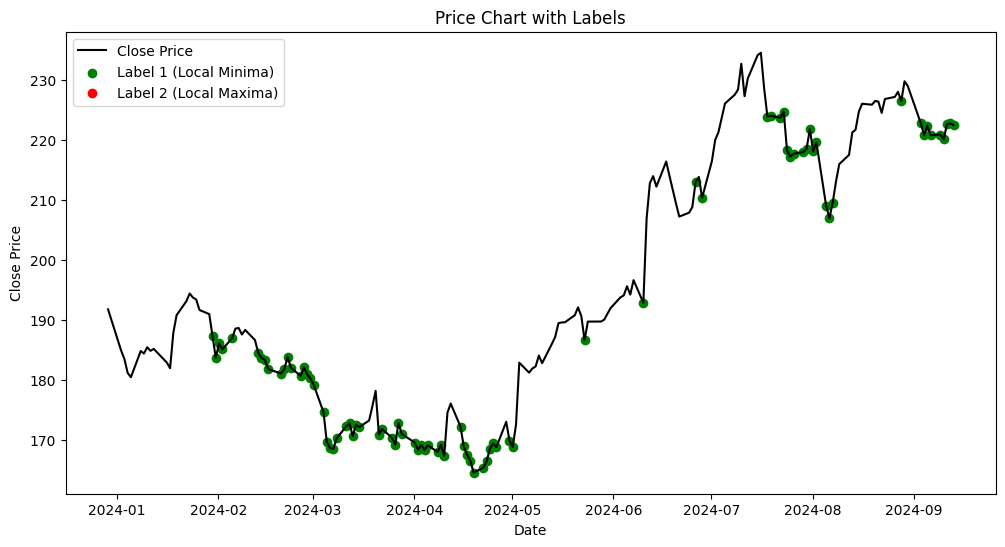

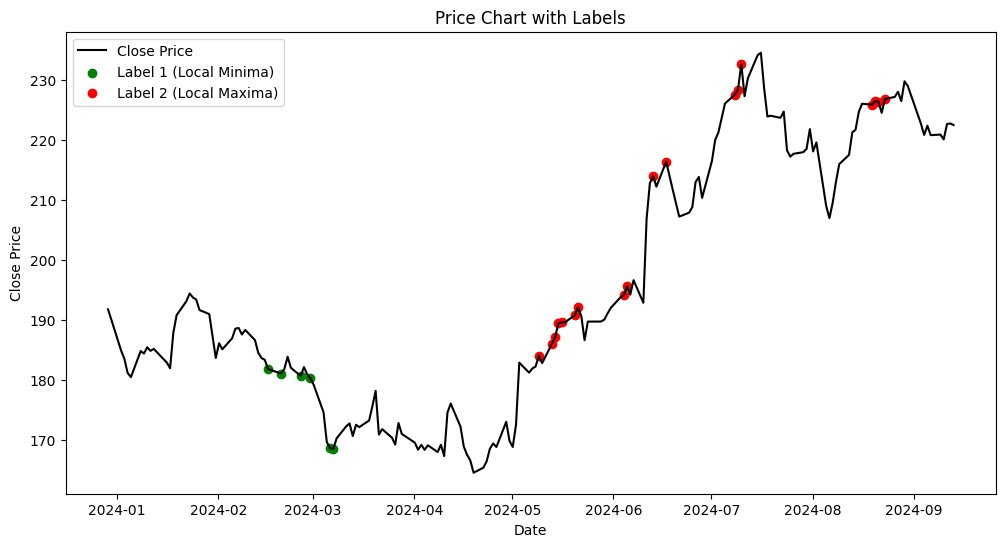

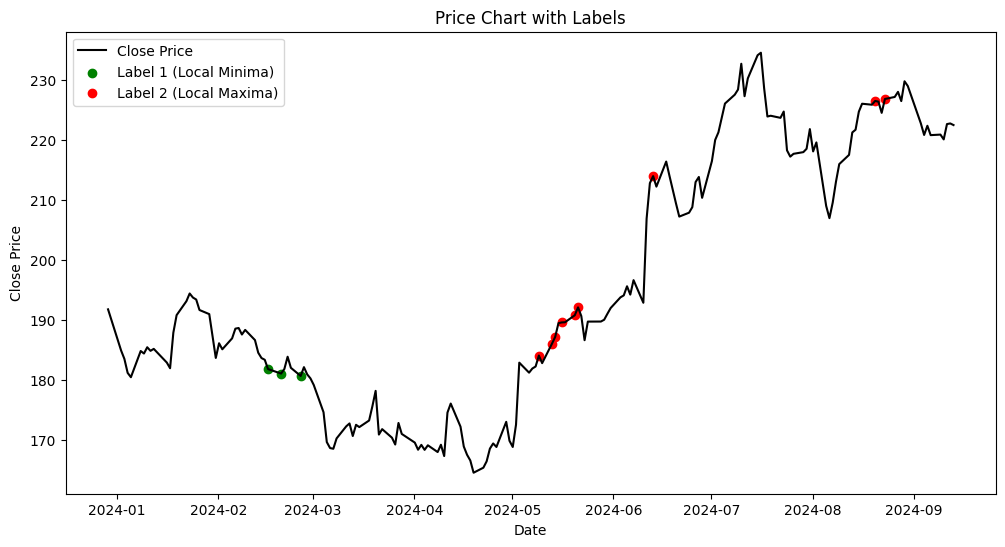

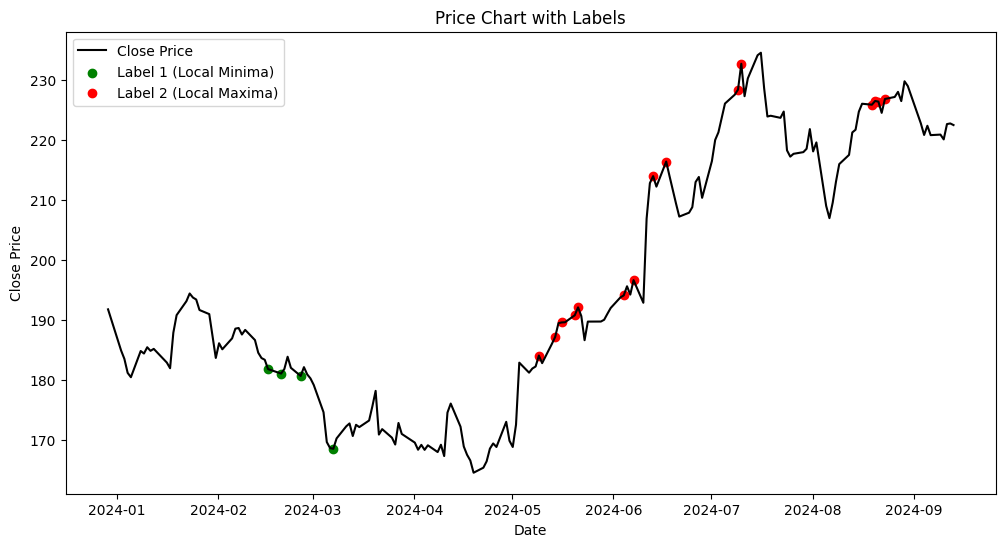

In [36]:
for i in ['Logistic Regression_pred', 'XGBoost_pred', 'Random Forest_pred', 'LightGBM_pred']:
    gambar(merged_df,target=i)